In [1]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [4]:
data = pd.concat([train, test], axis=0)

In [5]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

## Zeroed distances imputation
Some of the data points have 0 euclidian distance between entry and exit. Let's take a look at some of them

In [418]:
zeros = data[data.euclidian_distance==0]
train_zero_count = zeros[zeros.hash.isin(list(train.hash.unique()))].shape[0]
test_zero_count = zeros[zeros.hash.isin(list(test.hash.unique()))].shape[0]

print('Total zeros: \t{}'.format(zeros.shape[0]))
print('Train zeros: \t{} \t{:.2f}%'.format(train_zero_count, 100*train_zero_count / zeros.shape[0]))
print('Test zeros: \t{}  \t{:.2f}%'.format(test_zero_count, 100*test_zero_count / zeros.shape[0]))

Total zeros: 	525233
Train zeros: 	434014 	82.63%
Test zeros: 	91219  	17.37%


In [424]:
zeros[zeros.hash.isin(test.hash.unique())].head(10)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,harvesine_distance
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,12:21:37,12:21:37,0.0,0.0,0.0,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07,0.0,0.0,0.0
9,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_2,11:09:02,11:09:02,NaN,NaN,NaN,3.755349e+06,-1.916135e+07,3.755349e+06,-1.916135e+07,0.0,0.0,0.0
11,0005401ceddaf27a9b7f0d42ef1fbe95_1,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_0,09:10:03,09:10:03,NaN,NaN,NaN,3.751328e+06,-1.916236e+07,3.751328e+06,-1.916236e+07,0.0,0.0,0.0
12,0005401ceddaf27a9b7f0d42ef1fbe95_1,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_1,09:37:39,09:37:39,NaN,NaN,NaN,3.751349e+06,-1.916284e+07,3.751349e+06,-1.916284e+07,0.0,0.0,0.0
18,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_0,00:37:06,00:37:06,NaN,NaN,NaN,3.769811e+06,-1.935067e+07,3.769811e+06,-1.935067e+07,0.0,0.0,0.0
19,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_5,09:00:16,09:00:16,NaN,NaN,NaN,3.774369e+06,-1.926659e+07,3.774369e+06,-1.926659e+07,0.0,0.0,0.0
20,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_6,09:19:06,09:19:06,NaN,NaN,NaN,3.776419e+06,-1.917686e+07,3.776419e+06,-1.917686e+07,0.0,0.0,0.0
21,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_8,11:03:16,11:03:16,NaN,NaN,NaN,3.769801e+06,-1.935089e+07,3.769801e+06,-1.935089e+07,0.0,0.0,0.0
22,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_10,13:10:01,13:10:01,NaN,NaN,NaN,3.769801e+06,-1.935089e+07,3.769801e+06,-1.935089e+07,0.0,0.0,0.0
25,0006f84bb33ec929d1cda7686f861d0a_31,traj_0006f84bb33ec929d1cda7686f861d0a_31_1,12:50:07,12:50:07,NaN,NaN,NaN,3.759863e+06,-1.924467e+07,3.759863e+06,-1.924467e+07,0.0,0.0,0.0


Taking a closer look at a device with a considerable sequence of 0-distance trajectories

In [419]:
data[data.hash=='0002124248b0ca510dea42824723ccac_31']

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,harvesine_distance
12,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_1,09:56:08,09:56:08,NaN,NaN,NaN,3.765544e+06,-1.917227e+07,3.765544e+06,-1.917227e+07,0.000000,0.000000,0.000000
13,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_2,10:17:00,10:17:00,NaN,NaN,NaN,3.766338e+06,-1.917967e+07,3.766338e+06,-1.917967e+07,0.000000,0.000000,0.000000
14,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_4,12:38:33,12:38:33,NaN,NaN,NaN,3.767863e+06,-1.917851e+07,3.767863e+06,-1.917851e+07,0.000000,0.000000,0.000000
15,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_5,13:57:02,13:59:00,NaN,NaN,NaN,3.767864e+06,-1.917860e+07,3.767865e+06,-1.917859e+07,11.339560,12.397982,1257.463416
16,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_6,14:09:16,14:09:16,NaN,NaN,NaN,3.763879e+06,-1.921491e+07,3.763879e+06,-1.921491e+07,0.000000,0.000000,0.000000
17,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_7,14:19:32,14:19:32,NaN,NaN,NaN,3.759740e+06,-1.921491e+07,3.759740e+06,-1.921491e+07,0.000000,0.000000,0.000000
18,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_8,14:29:36,14:29:36,NaN,NaN,NaN,3.756596e+06,-1.921483e+07,3.756596e+06,-1.921483e+07,0.000000,0.000000,0.000000
19,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_9,14:39:37,14:59:01,NaN,NaN,NaN,3.760046e+06,-1.923746e+07,3.768391e+06,-1.920211e+07,36316.323808,43689.162713,6279.142351
20,0002124248b0ca510dea42824723ccac_31,traj_0002124248b0ca510dea42824723ccac_31_10,15:28:54,15:28:54,NaN,NaN,NaN,3.767866e+06,-1.917797e+07,3.767866e+06,-1.917797e+07,0.000000,0.000000,0.000000


In [420]:
data.shape

(1017199, 14)

In [335]:
print('Initial zero count: {}'.format(data[data.euclidian_distance==0].shape[0]))

data['next_x_entry'] = data.groupby('hash').x_entry.shift(-1)
data['next_y_entry'] = data.groupby('hash').y_entry.shift(-1)
data['next_time_entry'] = data.groupby('hash').time_entry.shift(-1)

zero = data[data.euclidian_distance==0]

zero['x_exit'] = zero['next_x_entry']
zero['y_exit'] = zero['next_y_entry']
zero['time_exit'] = zero['next_time_entry']

zero['euclidian_distance'] = np.sqrt(np.power(zero.x_entry.values-zero.x_exit.values, 2) + \
                                     np.power(zero.y_entry.values-zero.y_exit.values, 2))

zero['minkowski_distance'] = np.abs(zero.x_entry.values-zero.x_exit.values) + \
                             np.abs(zero.y_entry.values-zero.y_exit.values)

zero['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(zero.x_entry, zero.y_entry,
                                                                                  zero.x_exit, zero.y_exit)]

data[data.euclidian_distance==0] = zero

data = data.drop(columns=['next_x_entry', 'next_y_entry', 'next_time_entry'])

print('Final zero count: {}'.format(data[data.euclidian_distance==0].shape[0]))

Initial zero count: 525233
Final zero count: 3166


In [336]:
data = data[data.euclidian_distance!=0]
data.shape

(1014033, 14)

In [337]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,harvesine_distance,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,42364.863118,43047.231426,12862.173287,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,2989.643628,3841.346373,8654.581928,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,725.658561,776.090116,778.372842,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,1804.576849,1874.414413,2795.739484,0.173281,0.132425,0.711798,0.044184,0.184758


In [338]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,harvesine_distance,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,42364.863118,43047.231426,12862.173287,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,2989.643628,3841.346373,8654.581928,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,725.658561,776.090116,778.372842,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,1804.576849,1874.414413,2795.739484,9.928271,7.587407,40.782997,2.531528,10.585844


In [7]:
# transforming time variable to timedelta format in pandas
data['minute_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [9]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [8]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

In [10]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

In [11]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

In [344]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)

In [12]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [13]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.loc[data.time_delta_blind < 0, 'distance_blind'] = 0

data.loc[data.time_delta_blind < 0, 'x_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'y_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'time_delta_blind'] = 0

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_entry,is_inside_city_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,14.416667,64.565305,551.388913,555.156205


In [14]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

In [15]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [16]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [17]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [18]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [19]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [353]:
#data['velocity'] = data['euclidian_distance'] / data['deltat_min']
#data['acceleration'] = data['haversineersinelidian_distance'] / data['deltat_min']

In [20]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])


center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [21]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

data['distance_left_border'] = [distance_to_border(x, y, direction='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_to_border(x, y, direction='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_to_border(x, y, direction='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_to_border(x, y, direction='upper') for x, y in zip(data.x_entry, data.y_entry)]

In [22]:
def has_crossed_city(row):
    
    is_inside_city_entry = is_inside_city(row['x_entry'], row['y_entry'])
    is_inside_city_exit  = is_inside_city(row['x_exit'], row['y_exit'])
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
        return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 0
    
    
    if line.intersects(center_polygon) and is_inside_city_entry == 0 and is_inside_city_exit == 1:
        return 1
    
    return 0

#data['has_crossed_city'] = data.progress_apply(has_crossed_city, axis=1)

For full trigonometric observation, let's keep track of angles in degrees.

### Aggregating features

In [113]:
data.columns.tolist()

['hash',
 'trajectory_id',
 'time_entry',
 'time_exit',
 'vmax',
 'vmin',
 'vmean',
 'x_entry',
 'y_entry',
 'x_exit',
 'y_exit',
 'euclidian_distance',
 'minkowski_distance',
 'harvesine_distance',
 'minute_entry',
 'minute_exit',
 'hour_entry',
 'hour_exit',
 'is_inside_city_entry',
 'is_inside_city_exit',
 'first_quadrant_entry',
 'third_quadrant_entry',
 'fourth_quadrant_entry',
 'second_quadrant_entry',
 'center_permanency',
 'time_delta_blind',
 'x_delta_blind',
 'y_delta_blind',
 'distance_blind',
 'trajectory_number',
 'distance_cc_entry',
 'distance_cc_exit',
 'diff_cc_exit_entry',
 'deltat_min',
 'x_diff_entry',
 'x_diff_exit',
 'y_diff_entry',
 'y_diff_exit',
 'direction_entry',
 'direction_exit',
 'distance_left_border',
 'distance_right_border',
 'distance_lower_border',
 'distance_upper_border',
 'cc_middle_angle',
 'cc_xmin_ymin_angle',
 'cc_xmax_ymin_angle',
 'cc_xmin_ymax_angle',
 'cc_xmax_ymax_angle']

In [283]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hour_entry',
               'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry',
               'trajectory_number', 'distance_cc_entry', 'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry',
               'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

KeyError: "Columns not found: 'cc_xmin_ymin_angle', 'cc_xmax_ymax_angle', 'cc_middle_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymin_angle'"

# Sequence Data

In [23]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [24]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,y_diff_exit,direction_entry,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-80758.085309,-2.941300,-2.946875,54012.799354,59966.283785,54012.799354,113775.281047,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-53935.540259,-2.856258,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-51580.981406,-2.850029,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,-46679.383523,-2.811523,-2.811523,17723.201466,30883.843688,17723.201466,76913.184129,1.0,4.0,5


In [25]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,y_diff_exit,direction_entry,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-80758.085309,-2.941300,-2.946875,54012.799354,59966.283785,54012.799354,113775.281047,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-53935.540259,-2.856258,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-51580.981406,-2.850029,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,-46679.383523,-2.811523,-2.811523,17723.201466,30883.843688,17723.201466,76913.184129,1.0,4.0,5


In [26]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [27]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(167578, 200)

In [28]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,distance_upper_border_1,distance_upper_border_2,distance_upper_border_3,distance_upper_border_4,distance_upper_border_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113775.281047,84874.048910,83601.282594,76913.184129,73171.112481,5.0,5.0,5.0,5.0,5.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,0.0,0.0,0.507809,1.149404,NaN,0.0,0.0,0.507809,1.149404,...,NaN,56168.292879,58385.558020,57449.370585,57173.487146,NaN,4.0,4.0,4.0,4.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,104772.796688,167034.585072,NaN,NaN,NaN,2.0,2.0


In [29]:
data_sequence = data_sequence.reset_index()

In [30]:
data_sequence.shape

(167578, 201)

In [31]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(167543, 201)

In [32]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(134037, 201)

In [33]:
drop_cols = ['x_exit', 'y_exit', 'euclidian_distance', 'minkowski_distance',
            'harvesine_distance', 'minute_exit', 'is_inside_city_exit', 'center_permanency',
            'distance_cc_exit', 'diff_cc_exit_entry', 'x_diff_exit', 'y_diff_exit', 'direction_exit',
            'has_crossed_city', 'velocity']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [34]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

((107229, 201), (26808, 201))

In [35]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8883131433373014

In [ ]:
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

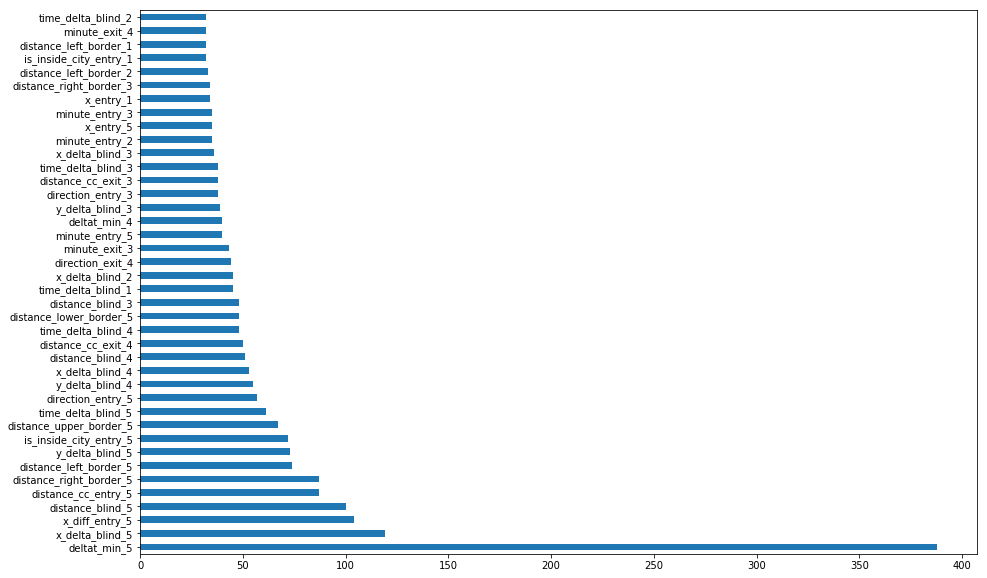

In [36]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(40).plot(kind='barh')

In [37]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [38]:
data_test.shape

(33515, 201)

In [39]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [40]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [41]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [42]:
pd.Series(yhat).value_counts()

0.0    25084
1.0     8431
dtype: int64

In [43]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,...,distance_upper_border_2,distance_upper_border_3,distance_upper_border_4,distance_upper_border_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,65404.767512,4509.406078,95494.014643,64044.642075,5.0,5.0,5.0,5.0,5.0,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,17.29,NaN,NaN,NaN,NaN,17.29,NaN,...,NaN,123831.025866,123831.025866,132459.301053,NaN,NaN,3.0,3.0,3.0,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,108484.662209,47550.841439,29690.794562,NaN,NaN,3.0,3.0,3.0,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,46549.114443,46065.077886,146097.676428,NaN,NaN,3.0,3.0,3.0,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [44]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [306]:
submission.to_csv('../data/submission37_julio.csv', index=False)